# Partie IV: Modélisation

## ========================================
## NOTEBOOK 4 : MODÉLISATION ET MLFLOW
## Projet Classification de CV - LiveCareer
## ========================================

### Modélisation - Classification de CV avec MLflow
 
### **Objectif** : Entraîner plusieurs modèles ML et comparer leurs performances avec MLflow

### 1. Configuration et Imports

In [18]:
!pip install mlflow

  Using cached sqlparse-0.5.5-py3-none-any.whl.metadata (4.7 kB)
  Using cached uvicorn-0.40.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached cffi-2.0.0-cp312-cp312-win_amd64.whl.metadata (2.6 kB)
  Using cached starlette-0.50.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached pydantic-2.12.5-py3-none-any.whl.metadata (90 kB)
  Using cached annotated_doc-0.0.4-py3-none-any.whl.metadata (6.6 kB)
  Using cached pydantic_core-2.41.5-cp312-cp312-win_amd64.whl.metadata (7.4 kB)
  Using cached typing_inspection-0.4.2-py3-none-any.whl.metadata (2.6 kB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.7 MB 3.4 MB/s eta 0:00:03
   ------- -------------------------------- 1.8/9.7 MB 5.6 MB/s eta 0:00:02
   --------------- ------------------------ 3.7/9.7 MB 7.0 MB/s eta 0:00:01
   ------------------------ --------------- 6.0/9.7 MB 8.2 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.7 MB 8.5 MB/s eta 0:0

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.0.0 requires cryptography<43,>=41.0.5, but you have cryptography 46.0.4 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 6.33.5 which is incompatible.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz
import pickle
import warnings

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, classification_report, confusion_matrix)

# MLflow
import mlflow
import mlflow.sklearn

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print(" Imports réussis!")

 Imports réussis!


### 2. Configuration MLflow

In [3]:
import sys
print(sys.executable)

C:\Users\Easy Services Pro\anaconda3\python.exe


In [3]:
# Configurer MLflow
MLFLOW_TRACKING_URI = "http://localhost:5000"
EXPERIMENT_NAME = "cv-classification-notebook"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print(f" MLflow configuré")
print(f"   - Tracking URI: {MLFLOW_TRACKING_URI}")
print(f"   - Expérience: {EXPERIMENT_NAME}")
print(f"\n Accédez à l'interface: {MLFLOW_TRACKING_URI}")

2026/02/08 13:37:47 INFO mlflow.tracking.fluent: Experiment with name 'cv-classification-notebook' does not exist. Creating a new experiment.


 MLflow configuré
   - Tracking URI: http://localhost:5000
   - Expérience: cv-classification-notebook

 Accédez à l'interface: http://localhost:5000


### 3. Chargement des Données

In [5]:
# Charger le dataset original (pour les labels)
df = pd.read_csv('../data/processed/resume_cleaned.csv')

# Charger les features TF-IDF
X = load_npz('../data/processed/X_features.npz')

# Identifier la colonne de catégorie
category_col = 'Category'  # Ajustez selon votre dataset
y = df[category_col].values

print(f" Données chargées:")
print(f"   - Samples: {X.shape[0]}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Catégories uniques: {len(np.unique(y))}")
print(f"   - Type de features: Sparse matrix ({type(X)})")

 Données chargées:
   - Samples: 169
   - Features: 5000
   - Catégories uniques: 25
   - Type de features: Sparse matrix (<class 'scipy.sparse._csr.csr_matrix'>)


### 4. Préparation des Données

In [7]:
# Encoder les labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Afficher le mapping
print("\n MAPPING DES CATÉGORIES:")
print("="*60)
for i, category in enumerate(label_encoder.classes_[:10]):  # Top 10
    print(f"  {i:2d} → {category}")
if len(label_encoder.classes_) > 10:
    print(f"  ... et {len(label_encoder.classes_) - 10} autres")


 MAPPING DES CATÉGORIES:
   0 → Advocate
   1 → Arts
   2 → Automation Testing
   3 → Blockchain
   4 → Business Analyst
   5 → Civil Engineer
   6 → Data Science
   7 → Database
   8 → DevOps Engineer
   9 → DotNet Developer
  ... et 15 autres


In [9]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\n SPLIT DES DONNÉES:")
print(f"   - Train: {X_train.shape[0]} samples")
print(f"   - Test:  {X_test.shape[0]} samples")
print(f"   - Ratio: {X_test.shape[0]/X_train.shape[0]:.1%}")


 SPLIT DES DONNÉES:
   - Train: 135 samples
   - Test:  34 samples
   - Ratio: 25.2%


### 5. Définition des Modèles

In [11]:
# Dictionnaire de modèles à tester
models = {
    'Logistic_Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1,
        solver='lbfgs'
    ),
    'Random_Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient_Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ),
    'Naive_Bayes': MultinomialNB(alpha=0.1),
    'SVM_Linear': SVC(
        kernel='linear',
        random_state=42,
        max_iter=1000,
        probability=True
    )
}

print(f" {len(models)} modèles définis:")
for name in models.keys():
    print(f"   - {name}")

 5 modèles définis:
   - Logistic_Regression
   - Random_Forest
   - Gradient_Boosting
   - Naive_Bayes
   - SVM_Linear


### 6. Fonction d'Entraînement avec MLflow

In [13]:
def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test):
    """
    Entraîner un modèle et logger dans MLflow
    """
    print(f"\n{'='*70}")
    print(f" ENTRAÎNEMENT: {model_name}")
    print(f"{'='*70}")
    
    with mlflow.start_run(run_name=f"{model_name}"):
        # Logger les paramètres
        params = model.get_params()
        mlflow.log_params(params)
        mlflow.log_param("model_type", model_name)
        
        # Entraîner
        import time
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Prédictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculer les métriques
        metrics = {
            'train_accuracy': accuracy_score(y_train, y_pred_train),
            'test_accuracy': accuracy_score(y_test, y_pred_test),
            'precision': precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
            'recall': recall_score(y_test, y_pred_test, average='weighted', zero_division=0),
            'f1_score': f1_score(y_test, y_pred_test, average='weighted', zero_division=0),
            'training_time': training_time
        }
        
        # Logger les métriques
        mlflow.log_metrics(metrics)
        
        # Afficher les résultats
        print(f"\n RÉSULTATS:")
        print(f"   Train Accuracy: {metrics['train_accuracy']:.4f}")
        print(f"   Test Accuracy:  {metrics['test_accuracy']:.4f}")
        print(f"   Precision:      {metrics['precision']:.4f}")
        print(f"   Recall:         {metrics['recall']:.4f}")
        print(f"   F1-Score:       {metrics['f1_score']:.4f}")
        print(f"   Training time:  {metrics['training_time']:.2f}s")
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        
        # Logger le modèle
        mlflow.sklearn.log_model(model, "model")
        
        return model, metrics, cm

### 7. Entraînement de Tous les Modèles

In [15]:
# Stocker les résultats
results = {}
confusion_matrices = {}

# Entraîner chaque modèle
for model_name, model in models.items():
    try:
        trained_model, metrics, cm = train_and_log_model(
            model, model_name, X_train, y_train, X_test, y_test
        )
        results[model_name] = metrics
        confusion_matrices[model_name] = cm
    except Exception as e:
        print(f"\n Erreur avec {model_name}: {str(e)}")
        results[model_name] = None

print(f"\n Entraînement de tous les modèles terminé!")


 ENTRAÎNEMENT: Logistic_Regression


2026/02/08 13:39:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS:
   Train Accuracy: 0.9556
   Test Accuracy:  0.4412
   Precision:      0.2777
   Recall:         0.4412
   F1-Score:       0.3177
   Training time:  3.74s
🏃 View run Logistic_Regression at: http://localhost:5000/#/experiments/686229934293620533/runs/48cbf72f6add412c832d8151313c1d71
🧪 View experiment at: http://localhost:5000/#/experiments/686229934293620533

 ENTRAÎNEMENT: Random_Forest


2026/02/08 13:40:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS:
   Train Accuracy: 1.0000
   Test Accuracy:  0.7353
   Precision:      0.6884
   Recall:         0.7353
   F1-Score:       0.6879
   Training time:  0.44s
🏃 View run Random_Forest at: http://localhost:5000/#/experiments/686229934293620533/runs/86add00adac74e5783ccf97df5621d54
🧪 View experiment at: http://localhost:5000/#/experiments/686229934293620533

 ENTRAÎNEMENT: Gradient_Boosting


2026/02/08 13:43:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS:
   Train Accuracy: 1.0000
   Test Accuracy:  0.7059
   Precision:      0.6324
   Recall:         0.7059
   F1-Score:       0.6441
   Training time:  184.39s
🏃 View run Gradient_Boosting at: http://localhost:5000/#/experiments/686229934293620533/runs/50bbcdafed334d038e2f0e873aaa9a17
🧪 View experiment at: http://localhost:5000/#/experiments/686229934293620533

 ENTRAÎNEMENT: Naive_Bayes


2026/02/08 13:43:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS:
   Train Accuracy: 1.0000
   Test Accuracy:  0.7059
   Precision:      0.5966
   Recall:         0.7059
   F1-Score:       0.6255
   Training time:  0.01s
🏃 View run Naive_Bayes at: http://localhost:5000/#/experiments/686229934293620533/runs/d9cf8e52cde849a6bff34745aa6328e9
🧪 View experiment at: http://localhost:5000/#/experiments/686229934293620533

 ENTRAÎNEMENT: SVM_Linear


2026/02/08 13:43:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



 RÉSULTATS:
   Train Accuracy: 1.0000
   Test Accuracy:  0.6176
   Precision:      0.5539
   Recall:         0.6176
   F1-Score:       0.5480
   Training time:  0.27s
🏃 View run SVM_Linear at: http://localhost:5000/#/experiments/686229934293620533/runs/1770033526ff4c0ab49022bdf342182f
🧪 View experiment at: http://localhost:5000/#/experiments/686229934293620533

 Entraînement de tous les modèles terminé!


### 8. Comparaison des Modèles

In [17]:
# Créer un DataFrame de comparaison
comparison_data = []
for model_name, metrics in results.items():
    if metrics is not None:
        comparison_data.append({
            'Model': model_name,
            'Test Accuracy': metrics['test_accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1_score'],
            'Training Time (s)': metrics['training_time']
        })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Test Accuracy', ascending=False)

print("\n" + "="*80)
print(" COMPARAISON DES MODÈLES")
print("="*80)
print(df_comparison.to_string(index=False))

# Identifier le meilleur
best_model = df_comparison.iloc[0]
print(f"\n MEILLEUR MODÈLE: {best_model['Model']}")
print(f"   Test Accuracy: {best_model['Test Accuracy']:.4f}")



 COMPARAISON DES MODÈLES
              Model  Test Accuracy  Precision   Recall  F1-Score  Training Time (s)
      Random_Forest       0.735294   0.688375 0.735294  0.687908           0.437731
  Gradient_Boosting       0.705882   0.632353 0.705882  0.644118         184.393041
        Naive_Bayes       0.705882   0.596639 0.705882  0.625490           0.011005
         SVM_Linear       0.617647   0.553922 0.617647  0.548039           0.269387
Logistic_Regression       0.441176   0.277731 0.441176  0.317696           3.737096

 MEILLEUR MODÈLE: Random_Forest
   Test Accuracy: 0.7353


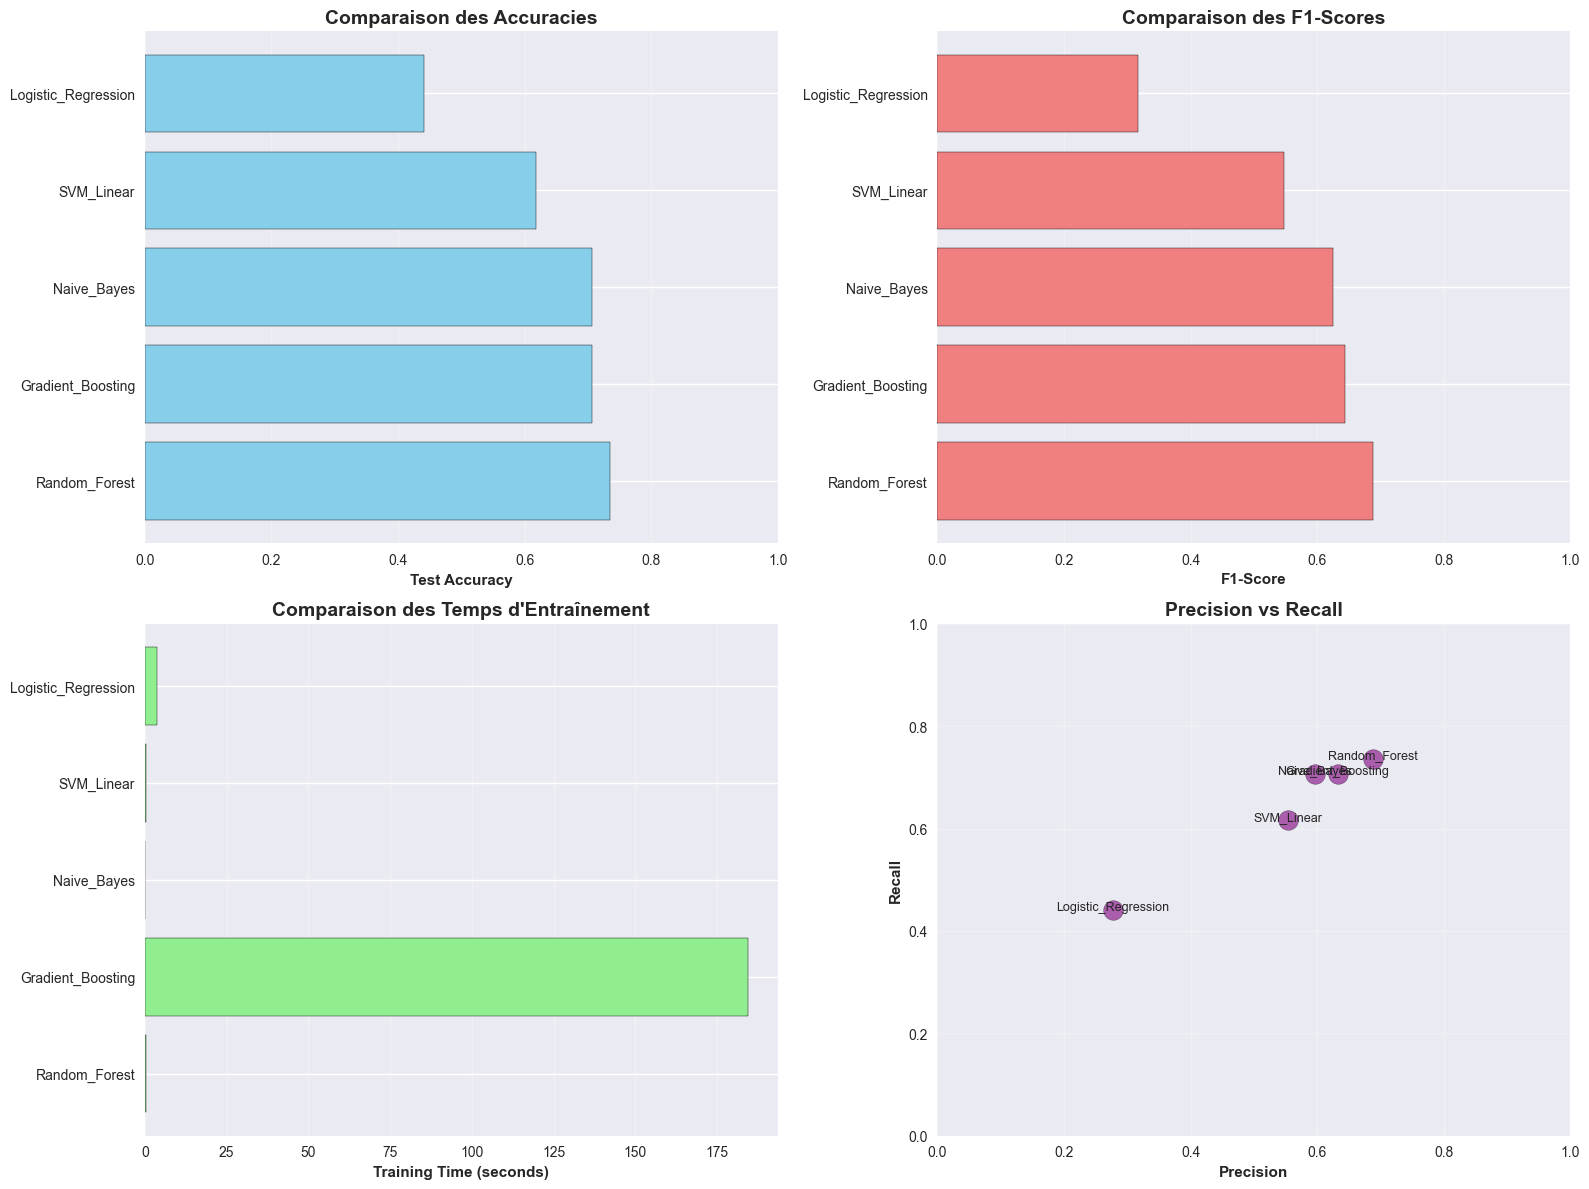

 Graphique sauvegardé dans outputs/plots/model_comparison.png


In [19]:
# Visualisation de la comparaison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
axes[0, 0].barh(df_comparison['Model'], df_comparison['Test Accuracy'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Test Accuracy', fontweight='bold')
axes[0, 0].set_title('Comparaison des Accuracies', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].set_xlim([0, 1])

# 2. F1-Score comparison
axes[0, 1].barh(df_comparison['Model'], df_comparison['F1-Score'], color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
axes[0, 1].set_title('Comparaison des F1-Scores', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].set_xlim([0, 1])

# 3. Training time comparison
axes[1, 0].barh(df_comparison['Model'], df_comparison['Training Time (s)'], color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1, 0].set_title('Comparaison des Temps d\'Entraînement', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Precision vs Recall
axes[1, 1].scatter(df_comparison['Precision'], df_comparison['Recall'], s=200, alpha=0.6, c='purple', edgecolor='black')
for idx, row in df_comparison.iterrows():
    axes[1, 1].annotate(row['Model'], (row['Precision'], row['Recall']), 
                       fontsize=9, ha='center')
axes[1, 1].set_xlabel('Precision', fontweight='bold')
axes[1, 1].set_ylabel('Recall', fontweight='bold')
axes[1, 1].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../outputs/plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graphique sauvegardé dans outputs/plots/model_comparison.png")


### 9. Confusion Matrix du Meilleur Modèle

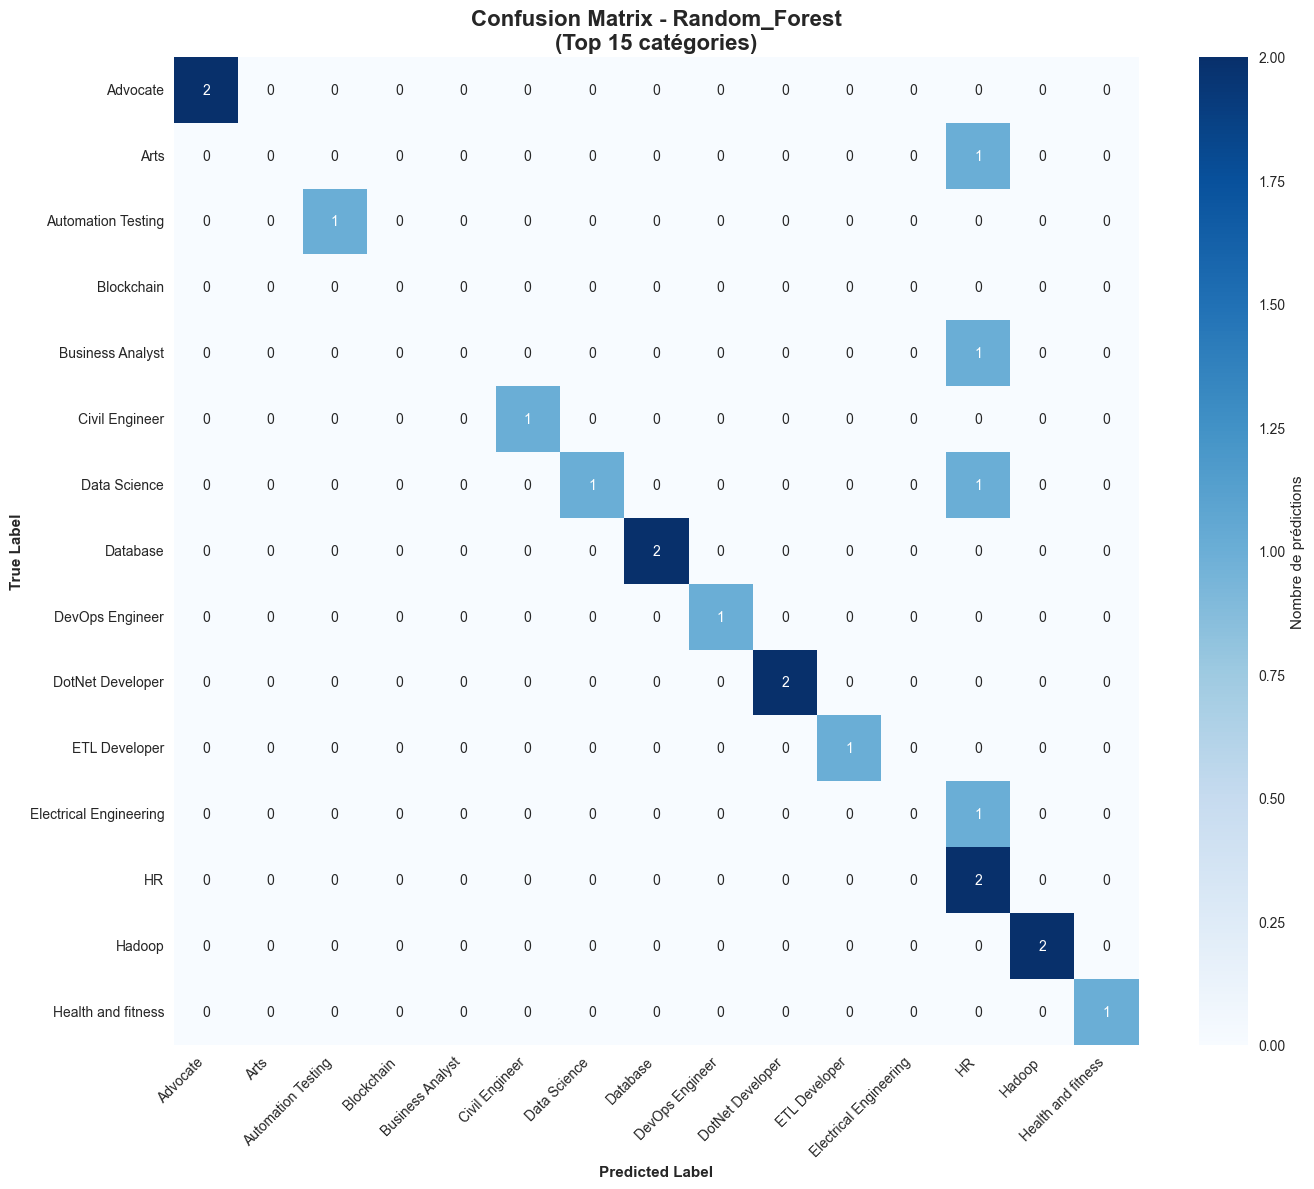

 Confusion matrix sauvegardée


In [21]:
# Obtenir le meilleur modèle
best_model_name = df_comparison.iloc[0]['Model']
best_cm = confusion_matrices[best_model_name]

# Visualiser la confusion matrix
plt.figure(figsize=(14, 12))

# Limiter aux 15 premières catégories pour la lisibilité
n_classes = min(15, len(label_encoder.classes_))
cm_display = best_cm[:n_classes, :n_classes]
classes_display = label_encoder.classes_[:n_classes]

sns.heatmap(cm_display, annot=True, fmt='d', cmap='Blues',
           xticklabels=classes_display,
           yticklabels=classes_display,
           cbar_kws={'label': 'Nombre de prédictions'})

plt.title(f'Confusion Matrix - {best_model_name}\n(Top {n_classes} catégories)', 
         fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'../outputs/plots/{best_model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f" Confusion matrix sauvegardée")

### 10. Classification Report Détaillé

In [23]:
# Récupérer les prédictions du meilleur modèle
best_trained_model = models[best_model_name]
y_pred_best = best_trained_model.predict(X_test)

# Classification report
print("\n" + "="*80)
print(f" CLASSIFICATION REPORT - {best_model_name}")
print("="*80)

report = classification_report(
    y_test, y_pred_best,
    target_names=label_encoder.classes_,
    digits=3
)
print(report)

# Sauvegarder le rapport
with open(f'../outputs/reports/{best_model_name}_classification_report.txt', 'w') as f:
    f.write(f"Classification Report - {best_model_name}\n")
    f.write("="*80 + "\n\n")
    f.write(report)

print(f"\n Rapport sauvegardé dans outputs/reports/{best_model_name}_classification_report.txt")


 CLASSIFICATION REPORT - Random_Forest
                           precision    recall  f1-score   support

                 Advocate      1.000     1.000     1.000         2
                     Arts      0.000     0.000     0.000         1
       Automation Testing      0.333     1.000     0.500         1
               Blockchain      0.000     0.000     0.000         1
         Business Analyst      0.000     0.000     0.000         1
           Civil Engineer      1.000     1.000     1.000         1
             Data Science      1.000     0.500     0.667         2
                 Database      1.000     1.000     1.000         2
          DevOps Engineer      0.500     1.000     0.667         1
         DotNet Developer      1.000     1.000     1.000         2
            ETL Developer      1.000     1.000     1.000         1
   Electrical Engineering      0.000     0.000     0.000         1
                       HR      0.286     1.000     0.444         2
                   Ha

### 11. Sauvegarde du Meilleur Modèle

In [25]:
# Sauvegarder le meilleur modèle
import pickle
from pathlib import Path

# Créer le dossier si nécessaire
Path('../models_saved').mkdir(parents=True, exist_ok=True)

# Sauvegarder le modèle
with open(f'../models_saved/{best_model_name}_model.pkl', 'wb') as f:
    pickle.dump(best_trained_model, f)

# Sauvegarder aussi comme "best_model.pkl"
with open('../models_saved/best_model.pkl', 'wb') as f:
    pickle.dump(best_trained_model, f)

# Sauvegarder le label encoder
with open('../models_saved/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print(f" Modèles sauvegardés:")
print(f"   - models_saved/{best_model_name}_model.pkl")
print(f"   - models_saved/best_model.pkl")
print(f"   - models_saved/label_encoder.pkl")

 Modèles sauvegardés:
   - models_saved/Random_Forest_model.pkl
   - models_saved/best_model.pkl
   - models_saved/label_encoder.pkl


### 12. Test de Prédiction

In [27]:
# Charger le vectorizer
with open('../models_saved/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# Exemple de CV test
test_cv = """
Experienced Python Developer with 5+ years in machine learning and data science.
Strong background in TensorFlow, scikit-learn, and deep learning.
Worked on multiple NLP projects and computer vision applications.
Skills: Python, SQL, Docker, AWS, Git, pandas, numpy
"""

print(" CV TEST:")
print("="*80)
print(test_cv)

# Nettoyer et vectoriser
from sys import path
path.append('../src/preprocessing')
from text_cleaner import TextCleaner

cleaner = TextCleaner()
cleaned_cv = cleaner.clean_text(test_cv)
X_test_cv = vectorizer.transform([cleaned_cv])

# Prédire
prediction = best_trained_model.predict(X_test_cv)[0]
probabilities = best_trained_model.predict_proba(X_test_cv)[0]

# Décoder la prédiction
predicted_category = label_encoder.inverse_transform([prediction])[0]
confidence = probabilities[prediction]

print("\n PRÉDICTION:")
print("="*80)
print(f"Catégorie prédite: {predicted_category}")
print(f"Confiance: {confidence:.2%}")

# Top 3 prédictions
top_3_indices = probabilities.argsort()[-3:][::-1]
print(f"\nTop 3 catégories:")
for i, idx in enumerate(top_3_indices, 1):
    category = label_encoder.inverse_transform([idx])[0]
    prob = probabilities[idx]
    print(f"  {i}. {category:30s} : {prob:.2%}")

 CV TEST:

Experienced Python Developer with 5+ years in machine learning and data science.
Strong background in TensorFlow, scikit-learn, and deep learning.
Worked on multiple NLP projects and computer vision applications.
Skills: Python, SQL, Docker, AWS, Git, pandas, numpy



[nltk_data] Downloading package wordnet to C:\Users\Easy Services
[nltk_data]     Pro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Easy Services
[nltk_data]     Pro\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



 PRÉDICTION:
Catégorie prédite: Data Science
Confiance: 25.58%

Top 3 catégories:
  1. Data Science                   : 25.58%
  2. HR                             : 11.03%
  3. Python Developer               : 9.06%


### 13. Résumé Final

In [29]:
print("\n" + "="*80)
print(" RÉSUMÉ DE LA MODÉLISATION")
print("="*80)

print(f"""
 MODÈLES ENTRAÎNÉS: {len(results)}

 MEILLEUR MODÈLE: {best_model_name}
   - Test Accuracy: {best_model['Test Accuracy']:.4f}
   - F1-Score: {best_model['F1-Score']:.4f}
   - Training Time: {best_model['Training Time (s)']:.2f}s

 FICHIERS SAUVEGARDÉS:
   - Modèle: models_saved/{best_model_name}_model.pkl
   - Label Encoder: models_saved/label_encoder.pkl
   - Confusion Matrix: outputs/plots/{best_model_name}_confusion_matrix.png
   - Classification Report: outputs/reports/{best_model_name}_classification_report.txt

 MLFLOW:
   - Toutes les expériences sont loggées dans MLflow
   - Accédez à l'interface: {MLFLOW_TRACKING_URI}
   - Expérience: {EXPERIMENT_NAME}

 PROCHAINES ÉTAPES:
   1. Analyser les erreurs de classification
   2. Tenter du fine-tuning des hyperparamètres
   3. Essayer des modèles plus avancés (BERT, etc.)
   4. Déployer l'API avec le meilleur modèle
""")


 RÉSUMÉ DE LA MODÉLISATION

 MODÈLES ENTRAÎNÉS: 5

 MEILLEUR MODÈLE: Random_Forest
   - Test Accuracy: 0.7353
   - F1-Score: 0.6879
   - Training Time: 0.44s

 FICHIERS SAUVEGARDÉS:
   - Modèle: models_saved/Random_Forest_model.pkl
   - Label Encoder: models_saved/label_encoder.pkl
   - Confusion Matrix: outputs/plots/Random_Forest_confusion_matrix.png
   - Classification Report: outputs/reports/Random_Forest_classification_report.txt

 MLFLOW:
   - Toutes les expériences sont loggées dans MLflow
   - Accédez à l'interface: http://localhost:5000
   - Expérience: cv-classification-notebook

 PROCHAINES ÉTAPES:
   1. Analyser les erreurs de classification
   2. Tenter du fine-tuning des hyperparamètres
   3. Essayer des modèles plus avancés (BERT, etc.)
   4. Déployer l'API avec le meilleur modèle



# -----------------------------------------------------------------------------------
### FIN DE LA MODÉLISATION

#### Le meilleur modèle est prêt à être déployé dans l'API !